# Train Vision Transformer for a single audio time slice

We make raw code blocks for more user functionality. Convert these to code blocks, thereby making custom models outside the scope of the command line interface.

### Non-CLI blocks

In [27]:
feature_file = 'dbr/mel.npy'
target_file = 'dbr/y.npy'
model_file = 'test_vit.pth'
test_size = 0.2
batch_size = 100
lr = 1e-4
random_state = 42
num_epochs = 100
optimize = 'adam'

In [1]:
patch_x = 16
patch_y = 32
hidden_size = 12
num_hidden_layers = 2
num_attention_heads = 6
intermediate_size = 12
hidden_dropout_prob = 0.1
attention_probs_dropout_prob = 0.1

### Papermill blocks

In [ ]:
# Parameters

yaml_file = None
feature_file = None
target_file = None
model_file = None

patch_x = None
patch_y = None
hidden_size = None
num_hidden_layers = None
num_attention_heads = None
intermediate_size = None
hidden_dropout_prob = None
attention_probs_dropout_prob = None

test_size = None
lr = None
num_epochs = None
batch_size = None
random_state = None
optimize = None

In [ ]:
import yaml
if yaml_file is None:
    pass
else:
    # yaml_file argument overwrites
    with open(yaml_file, 'r') as f:
        data = yaml.safe_load(f)

    # files
    feature_file = data['feature_file']
    target_file = data['target_file']
    model_file = data['model_file']

    # architecture
    patch_x = data['patch_x']
    patch_y = data['patch_y']
    hidden_size = data['hidden_size']
    num_hidden_layers = data['num_hidden_layers']
    num_attention_heads = data['num_attention_heads']
    intermediate_size = data['intermediate_size']
    hidden_dropout_prob = data['hidden_dropout_prob']
    attention_probs_dropout_prob = data['attention_probs_dropout_prob']

    # training
    test_size = data['test_size']
    lr = data['lr']
    num_epochs = data['num_epochs']
    batch_size = data['batch_size']
    random_state = data['random_state']
    optimize = data['optimize']

In [2]:
# Type enforcing
patch_x = int(patch_x)
patch_y = int(patch_y)
hidden_size = int(hidden_size)
num_hidden_layers = int(num_hidden_layers)
num_attention_heads = int(num_attention_heads)
intermediate_size = int(intermediate_size)
hidden_dropout_prob = float(hidden_dropout_prob)
attention_probs_dropout_prob = float(attention_probs_dropout_prob)

### Imports

In [7]:
# array data manipulation and plotting
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# deep learning
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from transformers import ViTConfig, ViTForImageClassification

# machine learning
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, \
    accuracy_score, \
    f1_score, \
    auc, \
    recall_score, \
    precision_score, \
    precision_recall_curve, \
    roc_curve
from sklearn.metrics import confusion_matrix

### Load data

In [8]:
X = np.load(feature_file)
y = np.load(target_file)

# Encode labels and split the dataset
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Split the data into training and testing sets
y_tensor = torch.tensor(y_encoded, dtype=torch.long)
X_tensor = torch.tensor(X, dtype=torch.float32).unsqueeze(1)
X_train, X_test, y_train, y_test = train_test_split(
    X_tensor, y_tensor, test_size=test_size, stratify=y_tensor, random_state=random_state
)

batch_size = batch_size
train_data = TensorDataset(X_train, y_train)
test_data = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

### Set up GPU device

In [9]:
!nvidia-smi

Tue Jun 24 10:13:23 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.124.06             Driver Version: 570.124.06     CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla V100-PCIE-16GB           On  |   00000000:3B:00.0 Off |                    0 |
| N/A   31C    P0             25W /  250W |       1MiB /  16384MiB |      0%   E. Process |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### Set up model

In [28]:
config = ViTConfig(
    image_size=(X[0].shape[0],X[0].shape[1]),
    patch_size=(patch_x,patch_y),
    num_channels=1,  # Adjust for your input data (e.g., 1 for grayscale, 3 for RGB)
    hidden_size=hidden_size,
    num_hidden_layers=num_hidden_layers,
    num_attention_heads=num_attention_heads,
    intermediate_size=intermediate_size,
    hidden_dropout_prob=hidden_dropout_prob,
    attention_probs_dropout_prob=attention_probs_dropout_prob,
    num_labels=len(np.unique(y_encoded)),
)
model = ViTForImageClassification(config)

# criterion choice
criterion = torch.nn.CrossEntropyLoss()

# optimizer logic
if optimize == 'adam':
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
elif optimize == 'sgd':
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
elif optimize == 'rmsprop':
    optimizer = torch.optim.RMSprop(model.parameters(), lr=lr)
else:
    raise ValueError("Optimizer input is adam, sgd, or rmsprop")    

model

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(1, 12, kernel_size=(16, 32), stride=(16, 32))
      )
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-1): 2 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=12, out_features=12, bias=True)
              (key): Linear(in_features=12, out_features=12, bias=True)
              (value): Linear(in_features=12, out_features=12, bias=True)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=12, out_features=12, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=12, out_features=12, bias=True)
            (intermediate_act_fn): 

### Train the model

In [30]:
# Training loop

model.to(device)

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0

    for inputs, labels in train_loader:

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Pass to GPU
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(inputs)

        # Compute the loss
        loss = criterion(outputs.logits, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Accumulate the loss
        running_loss += loss.item()

    # Print the average loss for this epoch
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss / len(train_loader):.4f}")

Epoch 1/100, Loss: 1.0793
Epoch 2/100, Loss: 1.0659
Epoch 3/100, Loss: 1.0491
Epoch 4/100, Loss: 1.0054
Epoch 5/100, Loss: 0.9546
Epoch 6/100, Loss: 0.9090
Epoch 7/100, Loss: 0.8765
Epoch 8/100, Loss: 0.8468
Epoch 9/100, Loss: 0.8172
Epoch 10/100, Loss: 0.7997
Epoch 11/100, Loss: 0.7760
Epoch 12/100, Loss: 0.7493
Epoch 13/100, Loss: 0.7259
Epoch 14/100, Loss: 0.7112
Epoch 15/100, Loss: 0.6932
Epoch 16/100, Loss: 0.6710
Epoch 17/100, Loss: 0.6526
Epoch 18/100, Loss: 0.6340
Epoch 19/100, Loss: 0.6228
Epoch 20/100, Loss: 0.6109
Epoch 21/100, Loss: 0.5897
Epoch 22/100, Loss: 0.5799
Epoch 23/100, Loss: 0.5681
Epoch 24/100, Loss: 0.5564
Epoch 25/100, Loss: 0.5354
Epoch 26/100, Loss: 0.5305
Epoch 27/100, Loss: 0.5197
Epoch 28/100, Loss: 0.4954
Epoch 29/100, Loss: 0.4921
Epoch 30/100, Loss: 0.4763
Epoch 31/100, Loss: 0.4780
Epoch 32/100, Loss: 0.4699
Epoch 33/100, Loss: 0.4451
Epoch 34/100, Loss: 0.4508
Epoch 35/100, Loss: 0.4250
Epoch 36/100, Loss: 0.4177
Epoch 37/100, Loss: 0.4092
Epoch 38/1

In [31]:
torch.save(model, model_file)

### Evaluate the model

In [ ]:
model = torch.load(model_file, weights_only=False)

In [37]:
model.to(device)

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        logits = outputs.logits.cpu().numpy()
        preds = np.argmax(logits, axis=1)
        all_preds.extend(preds)
        all_labels.extend(labels.cpu().numpy())

# Calculate accuracy
accuracy = accuracy_score(all_labels, all_preds)
print(f"Validation Accuracy: {accuracy:.4f}")

# Print classification report
print(classification_report(all_labels, all_preds, target_names=le.classes_))

Validation Accuracy: 0.9566
              precision    recall  f1-score   support

        bird       0.97      0.96      0.96       329
         dog       0.97      0.95      0.96       266
        rain       0.91      0.96      0.94       142

    accuracy                           0.96       737
   macro avg       0.95      0.96      0.95       737
weighted avg       0.96      0.96      0.96       737



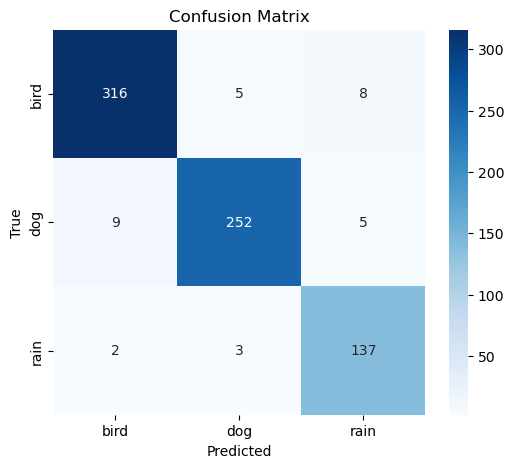

In [38]:
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# add some save of evaluation